Checkpoint A: imbalanced-learn (SMOTE) imported successfully.
Checkpoint B: Proceeding with CPU-only execution.
Scikit-learn RandomForestClassifier will be used for the model (CPU execution).
Checkpoint C: CPU-only mode confirmed.

--- Starting Operator ID Model Pipeline (V2 - CPU-only) ---
Loading data for Operator ID model using file map...
  Processing monday_benign.csv -> Operator Label: 0...
    Added 495338 samples.
  Processing tuesday_benign.csv -> Operator Label: 0...
    Added 395976 samples.
  Processing wednesday_benign.csv -> Operator Label: 0...
    Added 397053 samples.
  Processing thursday_benign.csv -> Operator Label: 0...
    Added 133770 samples.
  Processing friday_benign.csv -> Operator Label: 0...
    Added 364102 samples.
  Processing ftp_patator.csv -> Operator Label: 1...
    Added 9531 samples.
  Processing ssh_patator-new.csv -> Operator Label: 1...
    Added 5949 samples.
  Processing dos_golden_eye.csv -> Operator Label: 1...
    Added 8364 samples.
  Proc

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest selected 40 features.
Using 40 selected features for training.
Final features shape for training: (2433924, 40)
Final target shape: (2433924,)
Final Operator distribution in preprocessed data:
Operator
0    0.733893
1    0.266107
Name: proportion, dtype: float64

Splitting Operator ID data...
Train shape: X=(1825443, 40), y=(1825443,)
Test shape: X=(608481, 40), y=(608481,)

Scaling Operator ID features...

Performing Cross-Validation on Training Set using scikit-learn RF...
CV F1 Scores: [0.97841871 0.97779537 0.9783304 ]
CV Mean F1: 0.9782 +/- 0.0003
CV took 931.89s

Training final Operator ID model on full training data (scikit-learn RF)...
CPU Final Training complete in 490.46s.

--- Evaluating Operator ID Model on Test Set (CPU-only) ---
Test Accuracy: 0.9882
Test F1 Macro: 0.9850

Test Classification Report (0=Human, 1=Bot):
              precision    recall  f1-score   support

       Human      0.997     0.987     0.992    446560
         Bot      0.965     0.992   

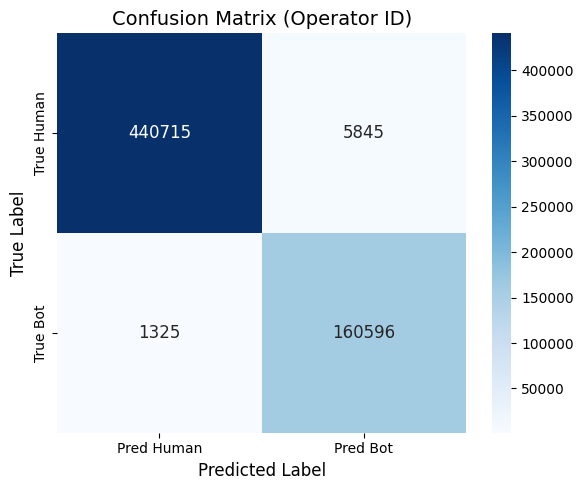


Test ROC AUC Score: 0.9984
Plot saved: /kaggle/working/operator_id_test_roc_curve.png


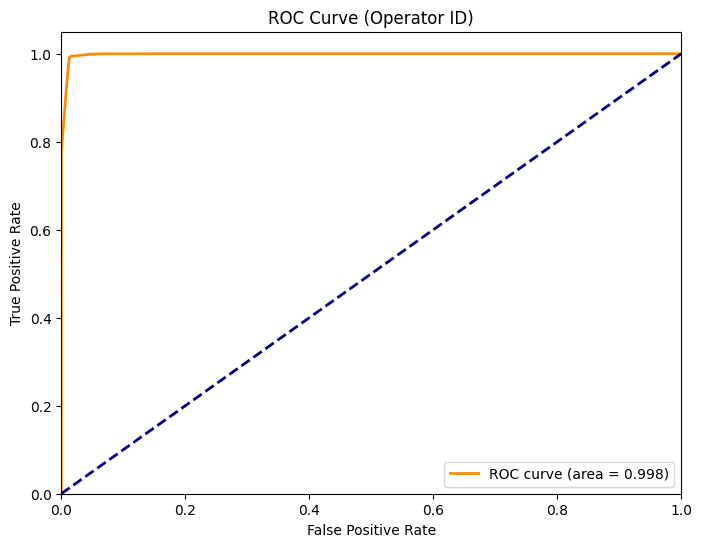


Saving Operator ID model artifacts (CPU-only)...
Operator ID artifacts saved: /kaggle/working/operator_id_model_cpu_sklearn_rf_FS_True.joblib, /kaggle/working/operator_id_scaler_cpu_sklearn_rf_FS_True.joblib

Saved Operator ID selected features list (40 features used for training) to: /kaggle/working/operator_id_selected_features.joblib

Plotting feature importances from CPU model...
Plot saved: /kaggle/working/operator_id_feature_importance.png


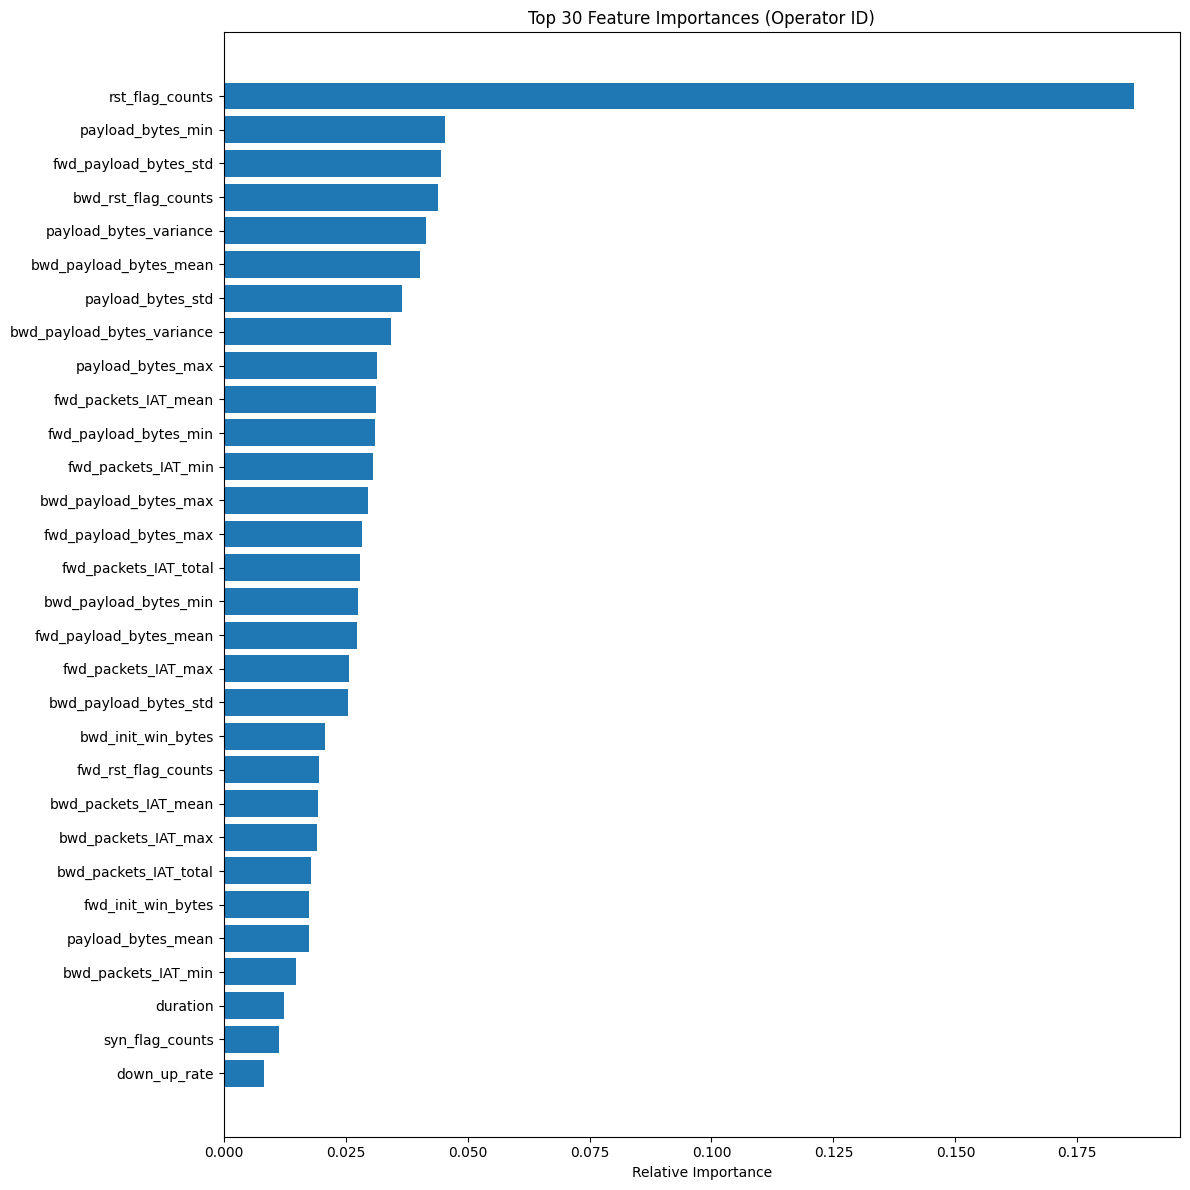


--- Operator ID Model Pipeline Finished Successfully ---


In [3]:
import pandas as pd
import numpy as np
import glob
import os
import time
import joblib # Make sure joblib is imported
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn Imports (Core) ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer # LabelEncoder not used here but good to keep
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, f1_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif as sklearn_f_classif
from sklearn.ensemble import RandomForestClassifier # This is the only RF we'll use

# --- imbalanced-learn imports ---
try:
    from imblearn.over_sampling import SMOTE # Kept, though not used in this specific script version
    imblearn_available = True
    print("Checkpoint A: imbalanced-learn (SMOTE) imported successfully.")
except ImportError as e:
    imblearn_available = False
    SMOTE = None # Define as None if import fails
    print(f"imblearn import failed: {e}")


print("Checkpoint B: Proceeding with CPU-only execution.")
print("Scikit-learn RandomForestClassifier will be used for the model (CPU execution).")
print("Checkpoint C: CPU-only mode confirmed.")


# --- Configuration ---
DATA_PATH = "/kaggle/input/network-intrusion-detection/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/" # Adjust if needed
OUTPUT_PATH = "/kaggle/working/" # Adjust if needed
RANDOM_STATE = 42

PERFORM_OPERATOR_FEATURE_SELECTION = True
N_OPERATOR_FEATURES_TO_SELECT = 40
GET_CPU_FEATURE_IMPORTANCE = True # This will always be true now

# --- V2: File Mappings and Labels for Operator ID Model ---
OPERATOR_FILE_MAP = {
    "monday_benign.csv": 0, "tuesday_benign.csv": 0, "wednesday_benign.csv": 0,
    "thursday_benign.csv": 0, "friday_benign.csv": 0, "ftp_patator.csv": 1,
    "ssh_patator-new.csv": 1, "dos_golden_eye.csv": 1, "dos_hulk.csv": 1,
    "dos_slowhttptest.csv": 1, "dos_slowloris.csv": 1, "botnet_ares.csv": 1,
    "portscan.csv": 1, "ddos_loit.csv": 1
}

# --- V2: Base Features using NEW Column Names ---
BASE_OPERATOR_FEATURES_V2 = [
    'duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count',
    'total_payload_bytes', 'fwd_total_payload_bytes', 'bwd_total_payload_bytes',
    'payload_bytes_mean', 'payload_bytes_std', 'payload_bytes_variance',
    'fwd_payload_bytes_mean', 'fwd_payload_bytes_std', 'fwd_payload_bytes_variance',
    'bwd_payload_bytes_mean', 'bwd_payload_bytes_std', 'bwd_payload_bytes_variance',
    'payload_bytes_max', 'payload_bytes_min', 'fwd_payload_bytes_max', 'fwd_payload_bytes_min',
    'bwd_payload_bytes_max', 'bwd_payload_bytes_min', 'fwd_init_win_bytes', 'bwd_init_win_bytes',
    'active_min', 'active_max', 'active_mean', 'active_std', 'idle_min', 'idle_max', 'idle_mean', 'idle_std',
    'bytes_rate', 'packets_rate', 'fwd_packets_rate', 'bwd_packets_rate', 'down_up_rate',
    'fin_flag_counts', 'psh_flag_counts', 'urg_flag_counts', 'ece_flag_counts', 'syn_flag_counts', 'ack_flag_counts', 'cwr_flag_counts', 'rst_flag_counts',
    'fwd_fin_flag_counts', 'fwd_psh_flag_counts', 'fwd_urg_flag_counts', 'fwd_syn_flag_counts', 'fwd_ack_flag_counts', 'fwd_rst_flag_counts',
    'bwd_fin_flag_counts', 'bwd_psh_flag_counts', 'bwd_urg_flag_counts', 'bwd_syn_flag_counts', 'bwd_ack_flag_counts', 'bwd_rst_flag_counts',
    'packets_IAT_mean', 'packet_IAT_std', 'packet_IAT_max', 'packet_IAT_min', 'packet_IAT_total',
    'fwd_packets_IAT_mean', 'fwd_packets_IAT_std', 'fwd_packets_IAT_max', 'fwd_packets_IAT_min', 'fwd_packets_IAT_total',
    'bwd_packets_IAT_mean', 'bwd_packets_IAT_std', 'bwd_packets_IAT_max', 'bwd_packets_IAT_min', 'bwd_packets_IAT_total',
    'subflow_fwd_packets', 'subflow_bwd_packets', 'subflow_fwd_bytes', 'subflow_bwd_bytes',
    'label' # Keep label for loading, drop later
]

# --- Helper Functions (Plotting) ---
def plot_confusion_matrix_binary(cm, title='Confusion Matrix (Operator ID)', save_path=None):
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Human', 'Pred Bot'], yticklabels=['True Human', 'True Bot'], annot_kws={"size": 12})
    plt.title(title, fontsize=14); plt.ylabel('True Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12); plt.tight_layout()
    if save_path: plt.savefig(os.path.join(OUTPUT_PATH, save_path), bbox_inches='tight'); print(f"Plot saved: {os.path.join(OUTPUT_PATH, save_path)}")
    plt.show(); plt.close()

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve (Operator ID)', save_path=None):
    if y_pred_proba is None: print("Cannot plot ROC: predict_proba data not available."); return
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba); roc_auc_val = auc(fpr, tpr) # Renamed auc to roc_auc_val to avoid conflict
    plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title); plt.legend(loc="lower right")
    if save_path: plt.savefig(os.path.join(OUTPUT_PATH, save_path), bbox_inches='tight'); print(f"Plot saved: {os.path.join(OUTPUT_PATH, save_path)}")
    plt.show(); plt.close()

def plot_feature_importance(model, feature_names, top_n=30, save_path=None):
    if not hasattr(model, 'feature_importances_'): print("Model doesn't support feature_importances_ plotting."); return
    importances = model.feature_importances_ # This will be a NumPy array from sklearn model
    if feature_names is None or not isinstance(feature_names, (list, np.ndarray)) or len(feature_names) != len(importances):
        print(f"Warning: Feature names mismatch/missing (expected {len(importances)}, got {len(feature_names) if feature_names is not None else 'None'}). Using generic names.")
        feature_names_safe = [f"Feature {i}" for i in range(len(importances))]
    else:
        feature_names_safe = np.array(feature_names)
    indices = np.argsort(importances)[::-1]; plot_n = min(top_n, len(feature_names_safe))
    if plot_n == 0: print("No features to plot importance for."); return
    plt.figure(figsize=(12, max(8, plot_n * 0.4))); plt.title(f'Top {plot_n} Feature Importances (Operator ID)')
    plt.barh(range(plot_n), importances[indices][:plot_n], align='center'); plt.yticks(range(plot_n), feature_names_safe[indices][:plot_n])
    plt.gca().invert_yaxis(); plt.xlabel('Relative Importance'); plt.tight_layout()
    if save_path: plt.savefig(os.path.join(OUTPUT_PATH, save_path), bbox_inches='tight'); print(f"Plot saved: {os.path.join(OUTPUT_PATH, save_path)}")
    plt.show(); plt.close()

# --- 1. V2: Load and Label Data based on Filenames ---
def load_operator_data_v2(data_path, file_map):
    """Loads files defined in file_map and assigns Operator label."""
    data_frames = []
    print(f"Loading data for Operator ID model using file map...")
    for filename, operator_label in file_map.items():
        file_path = os.path.join(data_path, filename)
        print(f"  Processing {filename} -> Operator Label: {operator_label}...")
        if not os.path.exists(file_path): print(f"    Warning: File not found: {file_path}. Skipping."); continue
        try:
            header = pd.read_csv(file_path, nrows=0).columns.tolist()
            # Ensure column names are stripped of leading/trailing whitespace for robust matching
            header = [col.strip() for col in header]
            base_features_stripped = [b_col.strip() for b_col in BASE_OPERATOR_FEATURES_V2]
            cols_to_load = [h_col for h_col in header if h_col in base_features_stripped]

            if not cols_to_load: print(f"    Skipping {filename}: No relevant columns found from BASE_OPERATOR_FEATURES_V2."); continue

            df_temp = pd.read_csv(file_path, usecols=cols_to_load, low_memory=False)
            df_temp.columns = [col.strip() for col in df_temp.columns] # Strip columns of loaded df
            df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)

            essential_cols = ['duration', 'packets_count', 'packets_IAT_mean']
            df_temp.dropna(subset=[col for col in essential_cols if col in df_temp.columns], inplace=True)
            if not df_temp.empty:
                df_temp['Operator'] = operator_label
                if 'label' in df_temp.columns: df_temp = df_temp.drop(columns=['label'])
                data_frames.append(df_temp); print(f"    Added {len(df_temp)} samples.")
            else: print(f"    File empty after NaN drop on essential columns.")
        except pd.errors.EmptyDataError: print(f"    Warning: Skipping empty file: {filename}")
        except pd.errors.ParserError as pe:
            print(f"    Error parsing {filename}: {pe}. Trying with engine='python'.")
            try:
                df_temp = pd.read_csv(file_path, usecols=cols_to_load, low_memory=False, engine='python')
                df_temp.columns = [col.strip() for col in df_temp.columns]
                df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
                df_temp.dropna(subset=[col for col in essential_cols if col in df_temp.columns], inplace=True)
                if not df_temp.empty:
                    df_temp['Operator'] = operator_label
                    if 'label' in df_temp.columns: df_temp = df_temp.drop(columns=['label'])
                    data_frames.append(df_temp); print(f"    Added {len(df_temp)} samples (with engine='python').")
                else: print(f"    File empty after NaN drop (with engine='python').")
            except Exception as e_py:
                print(f"    Error processing {filename} even with engine='python': {e_py}")
        except Exception as e: print(f"    Error processing {filename}: {e}")
    if not data_frames: raise ValueError("No dataframes loaded based on file map. Check file paths and column names.")
    operator_df = pd.concat(data_frames, ignore_index=True)
    print(f"\nCombined Operator ID dataset shape: {operator_df.shape}")
    print(f"Operator distribution:\n{operator_df['Operator'].value_counts(normalize=True)}")
    return operator_df

# --- 2. V2: Preprocess Operator Data (CPU-only, Revised with Optional FS) ---
def preprocess_operator_data_v2(df, base_feature_list, perform_fs=False, n_select=40, target_col='Operator'):
    """Prepares operator dataframe, optionally performs feature selection, RETURNS selected feature list."""
    print("Preprocessing Operator ID data (CPU-only)...")
    # Ensure base_feature_list items are stripped for matching
    base_feature_list_stripped = [b_col.strip() for b_col in base_feature_list]
    available_features = [col for col in base_feature_list_stripped if col in df.columns and col != target_col]

    if not available_features: raise ValueError("No base features found in DataFrame after stripping names.")
    X = df[available_features].copy(); y = df[target_col].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().sum().any():
        print("Warning: NaNs found before scaling. Imputing with column median.");
        X.fillna(X.median(), inplace=True)
        X.dropna(axis=1, how='all', inplace=True) # Drop cols if all NaN after median fill (unlikely)
    if X.empty: raise ValueError("Features empty after NaN handling.")

    X = X.select_dtypes(include=np.number)
    non_numeric_dropped = set(available_features) - set(X.columns)
    if non_numeric_dropped: print(f"Warning: Dropped non-numeric columns during dtype selection: {non_numeric_dropped}")

    if X.empty: raise ValueError("Features empty after numeric filtering.")
    y = y.loc[X.index] # Align y with X after potential row drops or numeric filtering
    current_feature_names = np.array(X.columns)

    selected_feature_names = current_feature_names.tolist() # Default to all current (numeric) features
    if perform_fs:
        print(f"\nPerforming Feature Selection for Operator ID (Target: {n_select} features) using scikit-learn SelectKBest...")
        k_actual = min(n_select, X.shape[1])
        if k_actual >= 1:
            # Ensure X values are clean for SelectKBest
            X_np_fs = np.nan_to_num(X.values, nan=0.0, posinf=np.finfo(np.float64).max/2, neginf=np.finfo(np.float64).min/2)
            selector_f_sklearn = SelectKBest(sklearn_f_classif, k=k_actual)
            try:
                selector_f_sklearn.fit(X_np_fs, y.values); selected_mask_f = selector_f_sklearn.get_support()
                selected_feature_names = current_feature_names[selected_mask_f].tolist()
                print(f"SelectKBest selected {len(selected_feature_names)} features.")
            except Exception as e: print(f"Sklearn SelectKBest failed: {e}. Using all numeric features."); selected_feature_names = current_feature_names.tolist()
        else: print("Warning: k < 1 for SelectKBest, using all numeric features.")
        X = X[selected_feature_names]; print(f"Using {X.shape[1]} selected features for training.")

    print(f"Final features shape for training: {X.shape}"); print(f"Final target shape: {y.shape}")
    print(f"Final Operator distribution in preprocessed data:\n{y.value_counts(normalize=True)}")
    return X, y, selected_feature_names

# --- 3. V2: Train Operator ID Model (CPU-only, Revised with CV) ---
def train_operator_model_v2(X_features_pd, y_target_series, random_state=42):
    """Splits, scales, trains scikit-learn RF model for operator ID. Includes CV evaluation."""
    print("\nSplitting Operator ID data...");
    # Ensure stratification if there are enough samples per class
    min_samples_per_class_for_stratify = 2 # StratifiedKFold usually needs at least 2 per class for each fold
    if y_target_series.value_counts().min() < min_samples_per_class_for_stratify * 3: # Assuming 3 folds for CV
        print("Warning: Not enough samples in the smallest class for reliable stratification. Splitting without stratify.")
        X_train_pd, X_test_pd, y_train, y_test = train_test_split(
            X_features_pd, y_target_series, test_size=0.25, random_state=random_state
        )
    else:
        X_train_pd, X_test_pd, y_train, y_test = train_test_split(
            X_features_pd, y_target_series, test_size=0.25, random_state=random_state, stratify=y_target_series
        )

    print(f"Train shape: X={X_train_pd.shape}, y={y_train.shape}"); print(f"Test shape: X={X_test_pd.shape}, y={y_test.shape}")
    print("\nScaling Operator ID features..."); scaler = PowerTransformer(method='yeo-johnson') # Or StandardScaler
    X_train_scaled = scaler.fit_transform(X_train_pd); X_test_scaled = scaler.transform(X_test_pd)

    model_params_sk = {'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 5,
                       'min_samples_split': 10, 'random_state': random_state,
                       'n_jobs': -1, 'class_weight': 'balanced'}

    print("\nPerforming Cross-Validation on Training Set using scikit-learn RF...")
    cv_model = RandomForestClassifier(**model_params_sk)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    f1_scorer = make_scorer(f1_score, average='binary', zero_division=0) # Ensure zero_division for f1
    start_cv = time.time()
    try:
        cv_scores = cross_val_score(cv_model, X_train_scaled, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
        print(f"CV F1 Scores: {cv_scores}"); print(f"CV Mean F1: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
    except ValueError as ve: # Catch errors if a split has only one class for binary F1
        print(f"CV failed due to ValueError (often from single class in a fold): {ve}. Check class balance.")
    except Exception as e: print(f"CV failed: {e}.")
    print(f"CV took {time.time() - start_cv:.2f}s")

    print("\nTraining final Operator ID model on full training data (scikit-learn RF)...")
    final_model_instance = RandomForestClassifier(**model_params_sk) # Re-init for final train on full train set
    start_time = time.time(); final_model_instance.fit(X_train_scaled, y_train);
    print(f"CPU Final Training complete in {time.time() - start_time:.2f}s.")

    return final_model_instance, X_test_scaled, y_test, scaler

# --- 4. V2: Evaluate Operator ID Model (CPU-only) ---
def evaluate_operator_model(model, X_test_data, y_test_actual, scaler, save_plots=True):
    """Evaluates the CPU operator ID model on the hold-out test set."""
    print("\n--- Evaluating Operator ID Model on Test Set (CPU-only) ---")
    y_pred = None; y_pred_proba = None
    try: y_pred = model.predict(X_test_data)
    except Exception as e: print(f"CPU Prediction failed: {e}"); return None
    if hasattr(model, 'predict_proba'):
        try: y_pred_proba = model.predict_proba(X_test_data)[:, 1] # Probability of positive class (1)
        except Exception as e: print(f"CPU predict_proba failed: {e}")

    if y_pred is None: print("Prediction is None, skipping evaluation metrics."); return None

    accuracy = accuracy_score(y_test_actual, y_pred); f1_macro = f1_score(y_test_actual, y_pred, average='macro', zero_division=0)
    print(f"Test Accuracy: {accuracy:.4f}"); print(f"Test F1 Macro: {f1_macro:.4f}")
    print("\nTest Classification Report (0=Human, 1=Bot):"); print(classification_report(y_test_actual, y_pred, target_names=['Human', 'Bot'], digits=3, zero_division=0))
    print("\nTest Confusion Matrix:"); cm = confusion_matrix(y_test_actual, y_pred);
    if save_plots: plot_confusion_matrix_binary(cm, save_path="operator_id_test_confusion_matrix.png")

    if y_pred_proba is not None:
        try:
            roc_auc_val = roc_auc_score(y_test_actual, y_pred_proba)
            print(f"\nTest ROC AUC Score: {roc_auc_val:.4f}");
            if save_plots: plot_roc_curve(y_test_actual, y_pred_proba, save_path="operator_id_test_roc_curve.png")
        except ValueError as ve_roc: # Can happen if only one class in y_test_actual for ROC AUC
            print(f"\nCould not calculate ROC AUC: {ve_roc}. Check test set class distribution.")
    else: print("\nTest ROC AUC Score: Not available (predict_proba failed or model doesn't support it).")

    print("\nSaving Operator ID model artifacts (CPU-only)...")
    model_type = "cpu_sklearn_rf" # Hardcoded for CPU
    fs_tag = f"_FS_{PERFORM_OPERATOR_FEATURE_SELECTION}" if PERFORM_OPERATOR_FEATURE_SELECTION else ""
    model_filename = os.path.join(OUTPUT_PATH, f"operator_id_model_{model_type}{fs_tag}.joblib")
    scaler_filename = os.path.join(OUTPUT_PATH, f"operator_id_scaler_{model_type}{fs_tag}.joblib")
    joblib.dump(model, model_filename); joblib.dump(scaler, scaler_filename)
    print(f"Operator ID artifacts saved: {model_filename}, {scaler_filename}")

    # Return feature names used by the model (if available)
    if hasattr(model, 'feature_names_in_'):
        return model.feature_names_in_
    return None # Fallback if not available


# --- Main Execution ---
if __name__ == "__main__":
    print("\n--- Starting Operator ID Model Pipeline (V2 - CPU-only) ---")
    warnings.filterwarnings("ignore", category=UserWarning) # General UserWarnings
    warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarnings

    try:
        # 1. Load and filter data
        operator_df = load_operator_data_v2(DATA_PATH, OPERATOR_FILE_MAP)
        if operator_df.empty:
            raise ValueError("Loaded operator_df is empty. Stopping execution.")

        # 2. Preprocess data (select features, handle NaNs, optional FS)
        X_op, y_op, op_selected_features_list = preprocess_operator_data_v2(
            operator_df,
            BASE_OPERATOR_FEATURES_V2, # Pass the original list for matching
            perform_fs=PERFORM_OPERATOR_FEATURE_SELECTION,
            n_select=N_OPERATOR_FEATURES_TO_SELECT
        )
        if X_op.empty or y_op.empty:
            raise ValueError("X_op or y_op is empty after preprocessing. Stopping execution.")


        # 3. Train model (CPU-only)
        op_model, X_op_test_scaled, y_op_test, op_scaler = train_operator_model_v2(
            X_op, y_op,
            random_state=RANDOM_STATE
        )

        # 4. Evaluate model on Test Set
        final_model_features_names_used = evaluate_operator_model( # Renamed to avoid conflict
            op_model, X_op_test_scaled, y_op_test.values,
            op_scaler, save_plots=True
        )

        # Save the selected features list (this list comes from preprocessing, before training)
        if PERFORM_OPERATOR_FEATURE_SELECTION and op_selected_features_list:
             features_filename = os.path.join(OUTPUT_PATH, "operator_id_selected_features.joblib")
             joblib.dump(op_selected_features_list, features_filename)
             print(f"\nSaved Operator ID selected features list ({len(op_selected_features_list)} features used for training) to: {features_filename}")

        # 5. Feature Importance Plotting (Always CPU model now)
        # Use the list of features that were ACTUALLY used for training the model.
        # This is `op_selected_features_list` if FS was done, or `X_op.columns` if FS was skipped.
        # `op_selected_features_list` from preprocess_operator_data_v2 already reflects this.
        feature_names_for_plot = op_selected_features_list

        if GET_CPU_FEATURE_IMPORTANCE and hasattr(op_model, 'feature_importances_') and feature_names_for_plot:
             print("\nPlotting feature importances from CPU model...")
             plot_feature_importance(op_model, feature_names_for_plot, top_n=30, save_path="operator_id_feature_importance.png")
        elif not hasattr(op_model, 'feature_importances_'):
             print("\nNOTE: Feature importance plotting skipped (model does not have 'feature_importances_').")
        elif not feature_names_for_plot:
             print("\nNOTE: Feature importance plotting skipped (feature names for plot are missing).")


        print("\n--- Operator ID Model Pipeline Finished Successfully ---")

    except FileNotFoundError as e: print(f"\nError: {e}. Check DATA_PATH.")
    except ValueError as e: print(f"\nValueError: {e}"); import traceback; traceback.print_exc()
    except ImportError as e: print(f"\nImportError: {e}"); import traceback; traceback.print_exc()
    except Exception as e: print(f"\nAn unexpected error occurred: {e}"); import traceback; traceback.print_exc()

In [4]:
# *** FIX: Save the selected features list using the captured variable ***
if PERFORM_OPERATOR_FEATURE_SELECTION and op_selected_features_list:
     features_filename = os.path.join(OUTPUT_PATH, "operator_id_selected_features.joblib")
     joblib.dump(op_selected_features_list, features_filename)
     print(f"\nSaved Operator ID selected features list ({len(op_selected_features_list)} features) to: {features_filename}")


Saved Operator ID selected features list (40 features) to: /kaggle/working/operator_id_selected_features.joblib
